# Network Intrusion Detection

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

## Loading the data set

We will start by extracting feature names from the kddcup names file. Since it does contain any name for the label, we will add a column name 'connection_type' for the labels (target variable).

In [245]:
kddcup_names = open("kddcup.names").read().split('\n')
feature_names = []
for feature_name in kddcup_names[1:]:
    feature_names.append(feature_name.split(':')[0].strip())

feature_names.append("connection_type")

Load the data sets into dataframes

In [246]:
kddcup_data = pd.read_csv("kddcup.data", names=feature_names, index_col=False)
kddcup_test_data = pd.read_csv("corrected", names=feature_names, index_col=False)

## Data Preprocessing

Now, we will do some preprocessing on the training and test data sets.

In [247]:
kddcup_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [248]:
kddcup_data.shape

(4898431, 42)

In [249]:
kddcup_test_data.shape

(311029, 42)

We want to perform numeric encoding on the categorical features. Pandas has a function get_dummies() for this. This function adds additional columns based on the categories present in the feature. To make sure that we have the same number of columns in the train and test sets, we combine the two data sets, perform encoding and then split them back.

In [250]:
data = pd.concat([kddcup_data, kddcup_test_data])

In [251]:
data = pd.get_dummies(data, columns=["protocol_type", "service", "flag"])
data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,215,45076,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,236,1228,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,233,2032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,239,486,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [252]:
train_data = pd.DataFrame(data.iloc[0:4898431,:])
train_data.shape

(4898431, 124)

In [253]:
test_data = pd.DataFrame(data.iloc[4898431:,:])
test_data.shape

(311029, 124)

Then, we check for missing values in the data set.

In [254]:
train_data.isnull().any().any()

False

There are no missing values in the data set.

In [255]:
train_data.connection_type.head()

0    normal.
1    normal.
2    normal.
3    normal.
4    normal.
Name: connection_type, dtype: object

We observe that there is an extra '.' in the 'connection_type' column after the connection type. For better visualization and interpretation, we remove the '.'.

In [256]:
train_data['connection_type'] = train_data['connection_type'].apply(lambda x : str(x)[:-1])
train_data.connection_type.head()

0    normal
1    normal
2    normal
3    normal
4    normal
Name: connection_type, dtype: object

Next, we check for duplicate rows and remove them from the training data set.

In [257]:
train_data = train_data.drop_duplicates()
train_data.shape

(1074992, 124)

Originally, we had 4898431 rows in the data set. After removing the duplicates, we have 1074992 rows. This shows that there were too many redundant rows in the data set. Since this data is a TCP dump, having same values is very much expected.

Next, we scale all the numeric features between 0 and 1. We are given a detailed description of the data set features denoting which features are continuous and which are discrete along with the data types.

In [258]:
numeric_features = train_data.dtypes[train_data.dtypes != "object"].index
min_max_scaler = MinMaxScaler().fit(train_data[numeric_features])
train_data[numeric_features] = min_max_scaler.transform(train_data[numeric_features])
train_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.558012e-07,3.441080e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.173944e-07,3.456654e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.710190e-07,9.374494e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.688450e-07,1.551219e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.731929e-07,3.710101e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Here, we are dealing with binary classification i.e. whether a connection is an attack or not. In our data set, columns are labelled as either 'normal' or as the attack type. So we need to need to denote normal connections as one class type and all the attack types as another class. The new class label would be 0 if the connection is normal and 1 if it is an attack.

In [259]:
train_data["label"] = train_data["connection_type"] != 'normal'
train_data["label"] = train_data["label"].apply(lambda x : int(x))
train_data.label.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

## Exploratory Analysis

Let's see how the attack types are distributed over the data set.

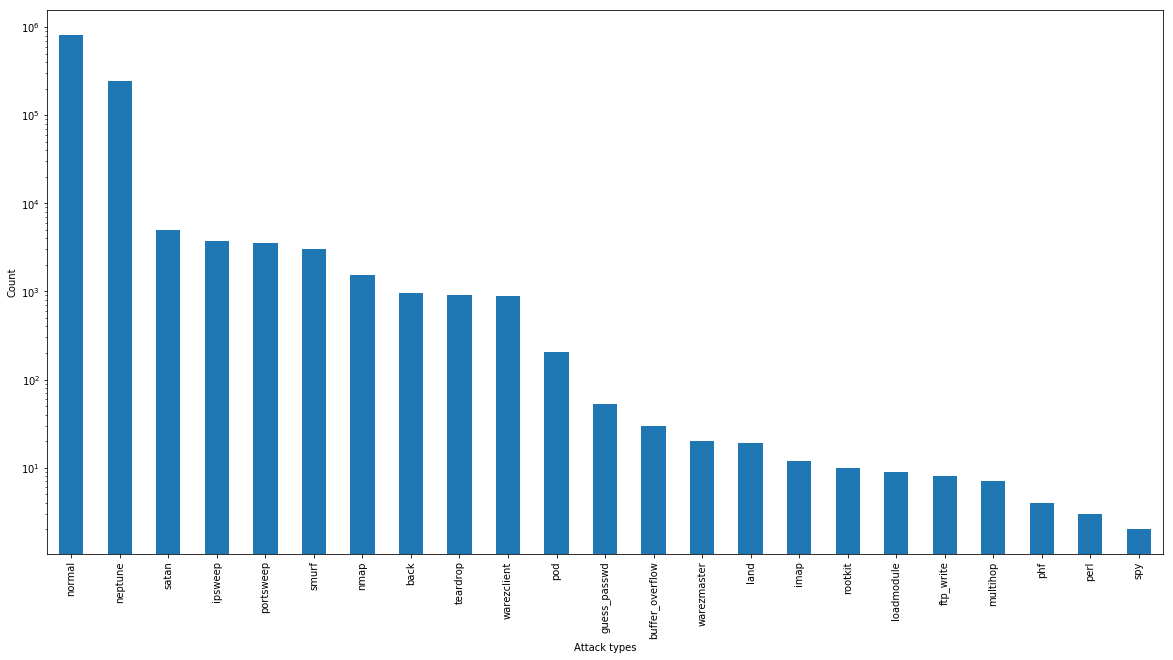

In [265]:
plt.figure(figsize=(20,10))
plt.yscale("log")
train_data["connection_type"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.xlabel("Attack types")
plt.show()

Let's see how the labels are distributed over the data set.

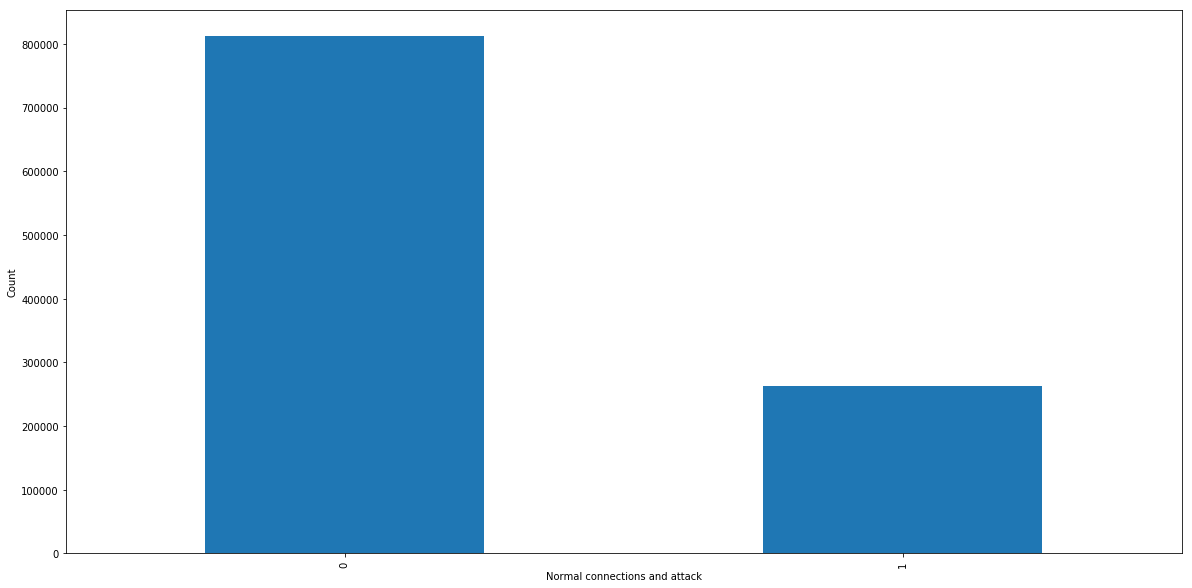

In [266]:
plt.figure(figsize=(20,10))
train_data["label"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.xlabel("Normal connections and attack")
plt.show()

We can see that the number of normal connections is significantly larger the number of attacks. Though this is expected and makes sense, it would not be feasible to use accuracy as the only metric while evaluating a model.

The other thing worth noting is that we have to be careful about false negatives. We cannot afford to have a connection identified as not being malicious when it is an attack. For this, we would plot the ROC curve and use Area Under Curve as an evaluation metric.

In [262]:
DF_normal = train_data[train_data["label"] == 0]
DF_attacked = train_data[train_data["label"] == 1]

In [269]:
def plotHists(i, threshold = 0):
    plt.figure(figsize = [10,10])
    plt.subplot(2, 1, 1)
    plt.title('Histogram for '+i+': Normal connections')
    plt.yscale('log')
    plt.hist(DF_normal[DF_normal[i] > threshold][i], bins=300, color='green')
    plt.ylabel("Count")
    plt.xlabel(i+" Values")
    plt.subplot(2, 1, 2)
    plt.title('Histogram for '+i+': Attacked connections')
    plt.yscale('log')
    plt.hist(DF_attacked[DF_attacked[i] > threshold][i], bins = 300, color='red')
    plt.ylabel("Count")
    plt.xlabel(i+" Values")
    plt.show()

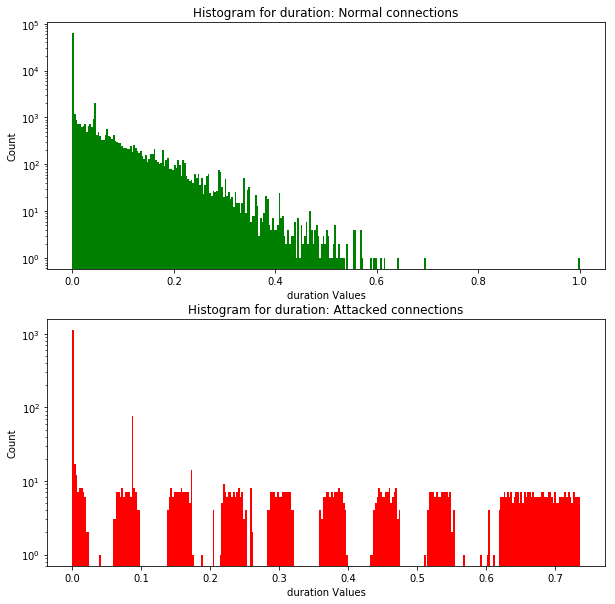

In [270]:
plotHists("duration")

We observe that the duration is concentrated towards smaller values in normal connections. Even though the duration values for attacks are spread over the entire range of values, we can conclude that if a connection's duration is more than 0.5, it might probably be an attack.

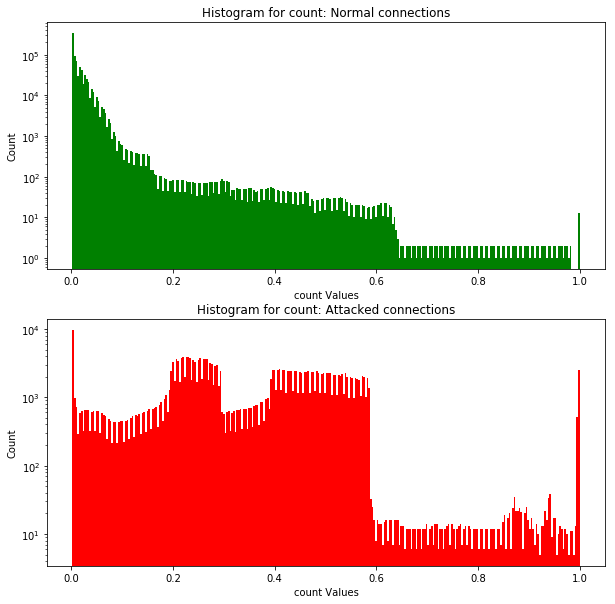

In [271]:
plotHists("count")

The count of number of connections to the same host is again concentrated at smaller values for normal connections. However, for attacks, there is a surge between values 0.2 and 0.6 which can be indicative of a malicious connection.

## Model Training

Now, we will drop the column "connection_type" since we no longer need it.

In [272]:
train_data = train_data.drop("connection_type", axis=1)
train_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label
0,0.0,1.558012e-07,3.441080e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.0,1.173944e-07,3.456654e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.0,1.710190e-07,9.374494e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.0,1.688450e-07,1.551219e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.0,1.731929e-07,3.710101e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


We will now build some classifiers and see how they perform.

In [273]:
random_forest = RandomForestClassifier().fit(train_data.iloc[:,:-1], train_data["label"])
random_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [274]:
gradient_boosting = GradientBoostingClassifier().fit(train_data.iloc[:,:-1], train_data["label"])
gradient_boosting

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [275]:
logreg = LogisticRegression().fit(train_data.iloc[:,:-1], train_data["label"])
logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [276]:
perceptron = Perceptron().fit(train_data.iloc[:,:-1], train_data["label"])
perceptron

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=5, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [277]:
multilayer_perceptron = MLPClassifier(hidden_layer_sizes=(100,)).fit(train_data.iloc[:,:-1], train_data["label"])
multilayer_perceptron

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Model Evaluation

To evaluate our classifiers, we will preprocess the test data as we did we our training data.

In [278]:
test_data.shape

(311029, 124)

We make sure there are no missing values.

In [279]:
test_data.isnull().any().any()

False

We will map and scale the features similarly.

In [280]:
test_data['connection_type'] = test_data['connection_type'].apply(lambda x : str(x)[:-1])
numeric_features = test_data.dtypes[test_data.dtypes != "object"].index
test_data[numeric_features] = min_max_scaler.transform(test_data[numeric_features])
test_data["label"] = test_data["connection_type"] != 'normal'
test_data["label"] = test_data["label"].apply(lambda x : int(x))
test_data = test_data.drop("connection_type", axis=1)
test_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label
0,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


We will test the models on our test data set and determine the most suited model for our problem.

In [281]:
print "For Random Forest classifier:\nAccuracy Score is: "
accuracy_score(test_data["label"], random_forest.predict(test_data.iloc[:,:-1])) * 100

For Random Forest classifier:
Accuracy Score is: 


92.398136508171262

In [282]:
models = []
fprs = []
tprs = []
roc_aucs = []

models.append("Random Forest")
fpr, tpr, thresholds = roc_curve(test_data["label"], random_forest.predict(test_data.iloc[:,:-1]))
roc_auc = auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
roc_aucs.append(roc_auc)

In [283]:
print "For Gradient Boosting classifier:\nAccuracy Score is: "
accuracy_score(test_data["label"], gradient_boosting.predict(test_data.iloc[:,:-1])) * 100

For Gradient Boosting classifier:
Accuracy Score is: 


92.600368454388487

In [284]:
models.append("Gradient Boosting")
fpr, tpr, thresholds = roc_curve(test_data["label"], gradient_boosting.predict(test_data.iloc[:,:-1]))
roc_auc = auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
roc_aucs.append(roc_auc)

In [285]:
print "For Logistic Regression classifier:\nAccuracy Score is: "
accuracy_score(test_data["label"], logreg.predict(test_data.iloc[:,:-1])) * 100

For Logistic Regression classifier:
Accuracy Score is: 


91.901719775326413

In [286]:
models.append("Logistic Regression")
fpr, tpr, thresholds = roc_curve(test_data["label"], logreg.predict(test_data.iloc[:,:-1]))
roc_auc = auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
roc_aucs.append(roc_auc)

In [287]:
print "For Perceptron classifier:\nAccuracy Score is: "
accuracy_score(test_data["label"], perceptron.predict(test_data.iloc[:,:-1])) * 100

For Perceptron classifier:
Accuracy Score is: 


81.304637188172165

In [288]:
models.append("Perceptron")
fpr, tpr, thresholds = roc_curve(test_data["label"], perceptron.predict(test_data.iloc[:,:-1]))
roc_auc = auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
roc_aucs.append(roc_auc)

In [289]:
print "For Multilayer Perceptron classifier:\nAccuracy Score is: "
accuracy_score(test_data["label"], multilayer_perceptron.predict(test_data.iloc[:,:-1])) * 100

For Multilayer Perceptron classifier:
Accuracy Score is: 


92.774628732368996

In [290]:
models.append("Multilayer Perceptron")
fpr, tpr, thresholds = roc_curve(test_data["label"], multilayer_perceptron.predict(test_data.iloc[:,:-1]))
roc_auc = auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
roc_aucs.append(roc_auc)

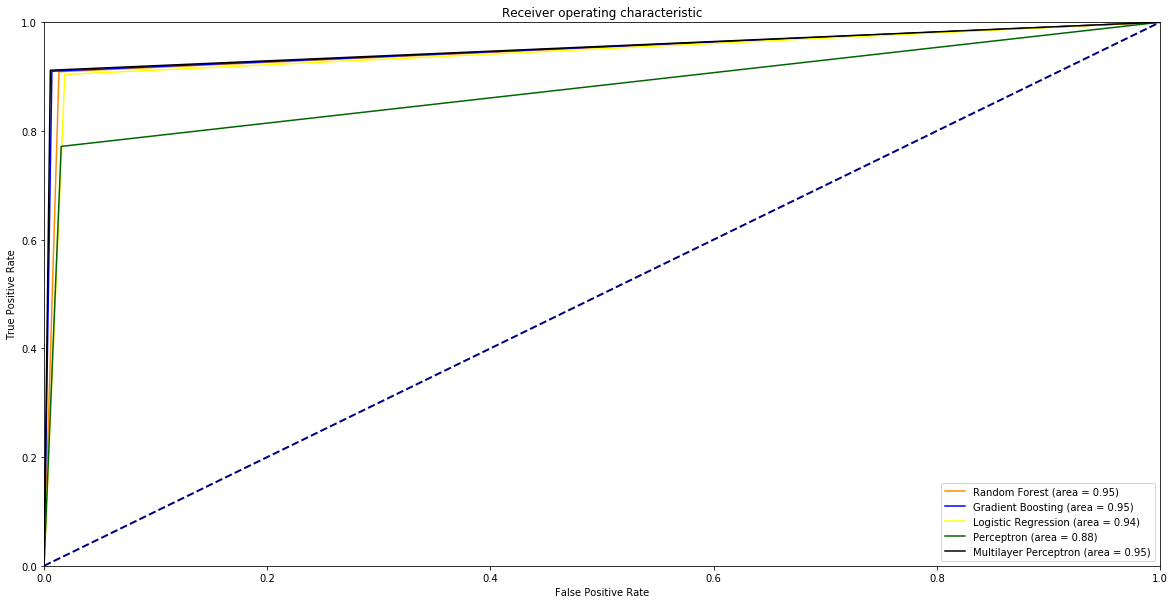

In [291]:
colors = ["darkorange", "blue", "yellow", "darkgreen", "black"]
plt.figure(figsize=(20,10))
for i in xrange(5):
    plt.plot(fprs[i], tprs[i], color=colors[i], label= models[i] + " (area = %0.2f)" % roc_aucs[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

We can see that the Random Forest classifier, Gradient Boosting Classifier and Logistic Regression work best for our problem.

Let's see which features are important and informative than the others. First, for Random Forest.

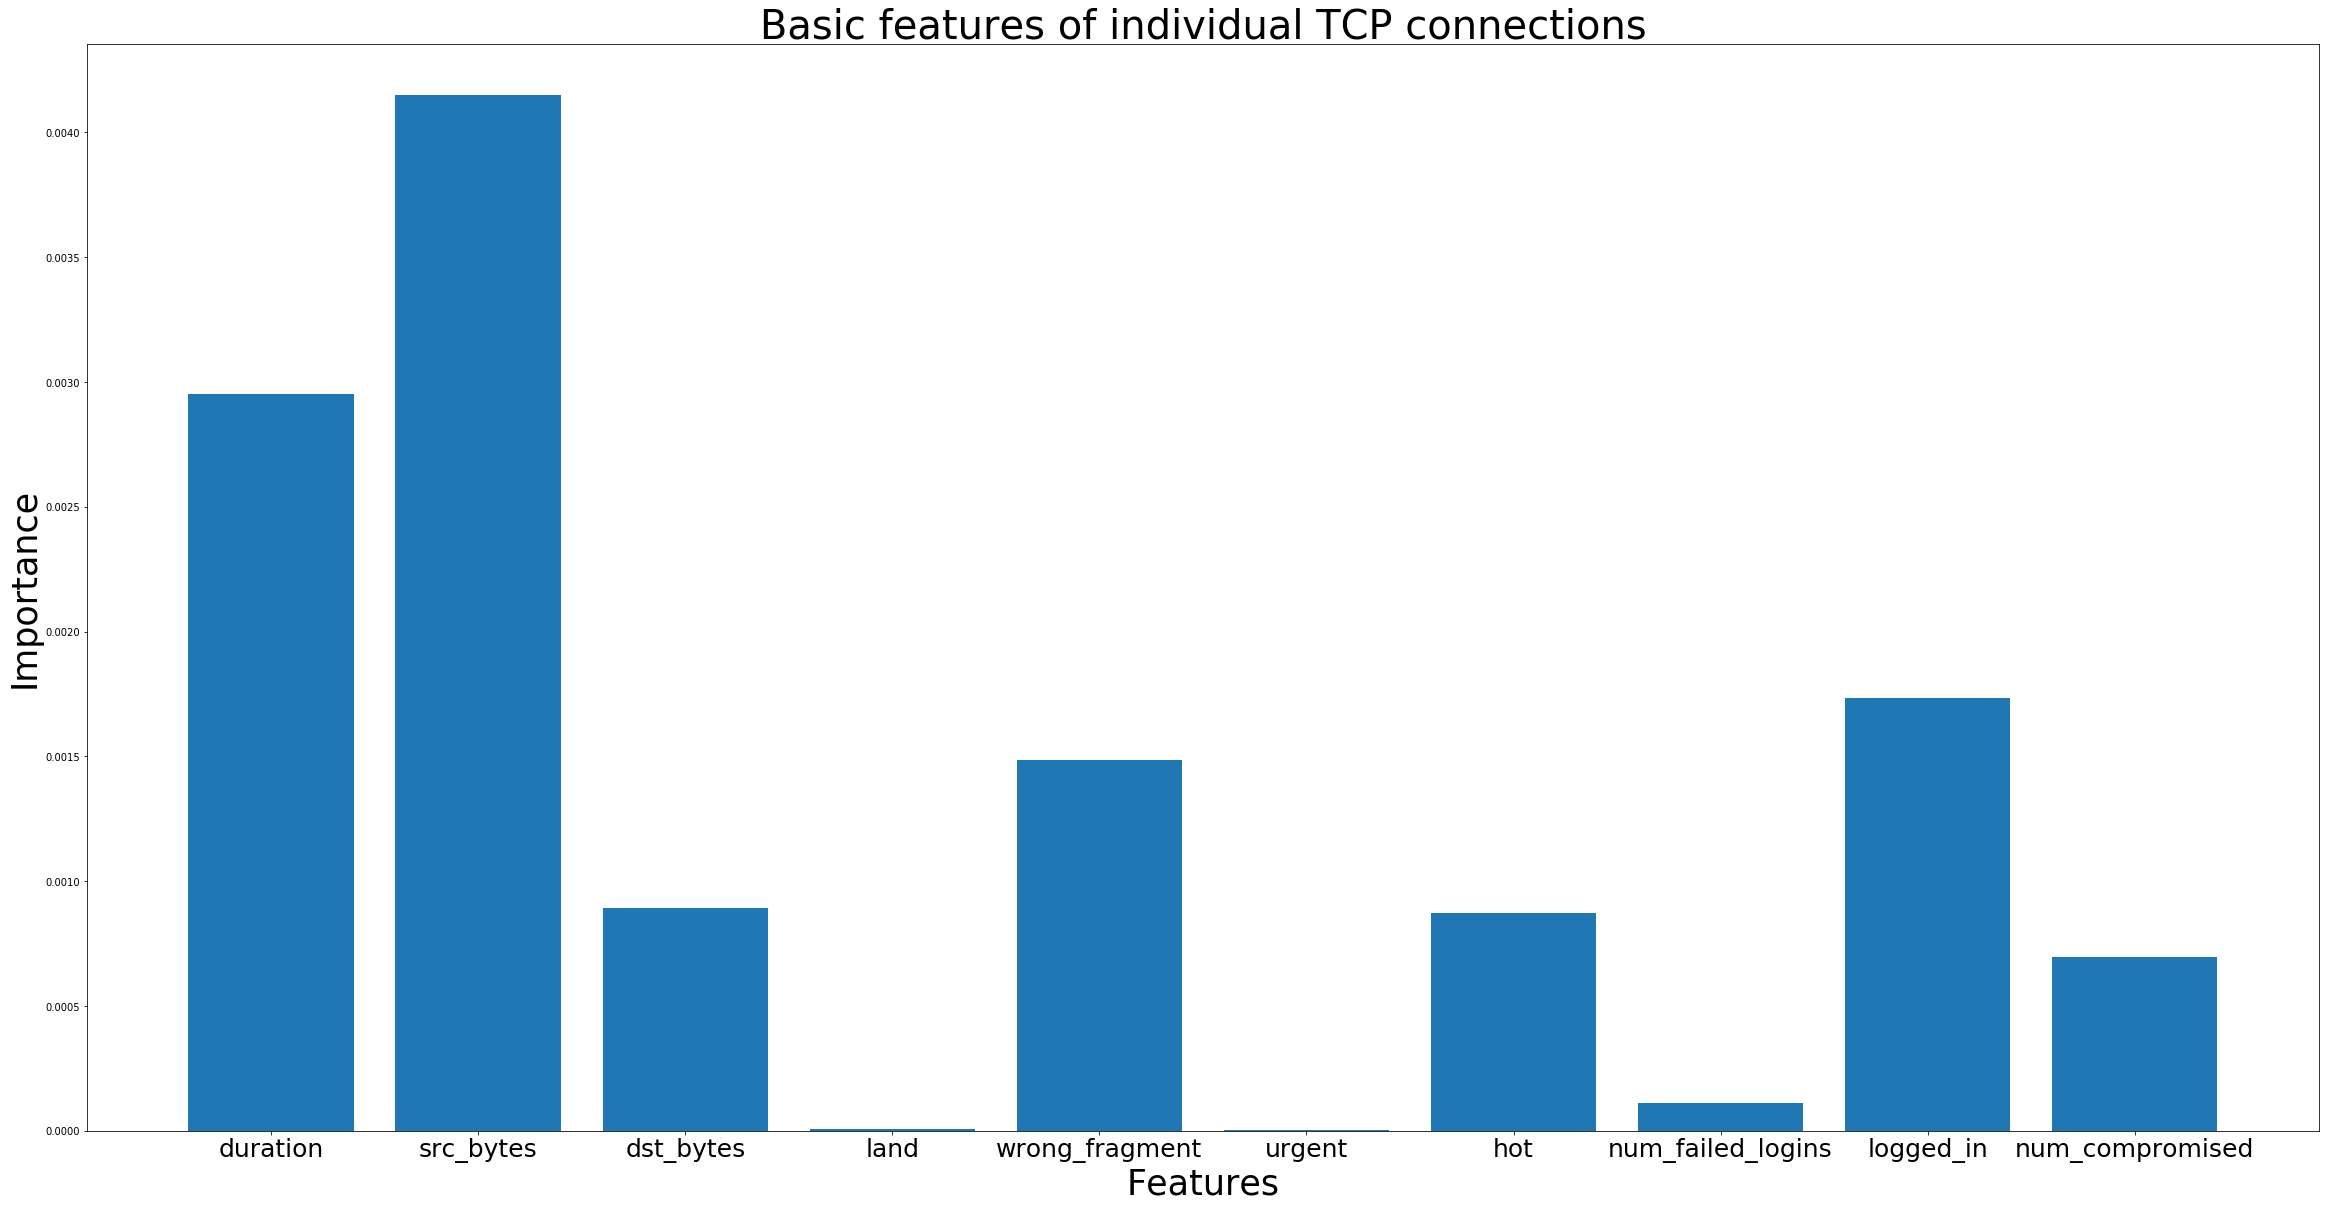

In [293]:
y_pos = np.arange(len(train_data.iloc[:,0:10].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, random_forest.feature_importances_[0:10], align='center')
plt.xticks(y_pos, train_data.iloc[:,0:10].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Basic features of individual TCP connections", fontsize=40)
plt.show()

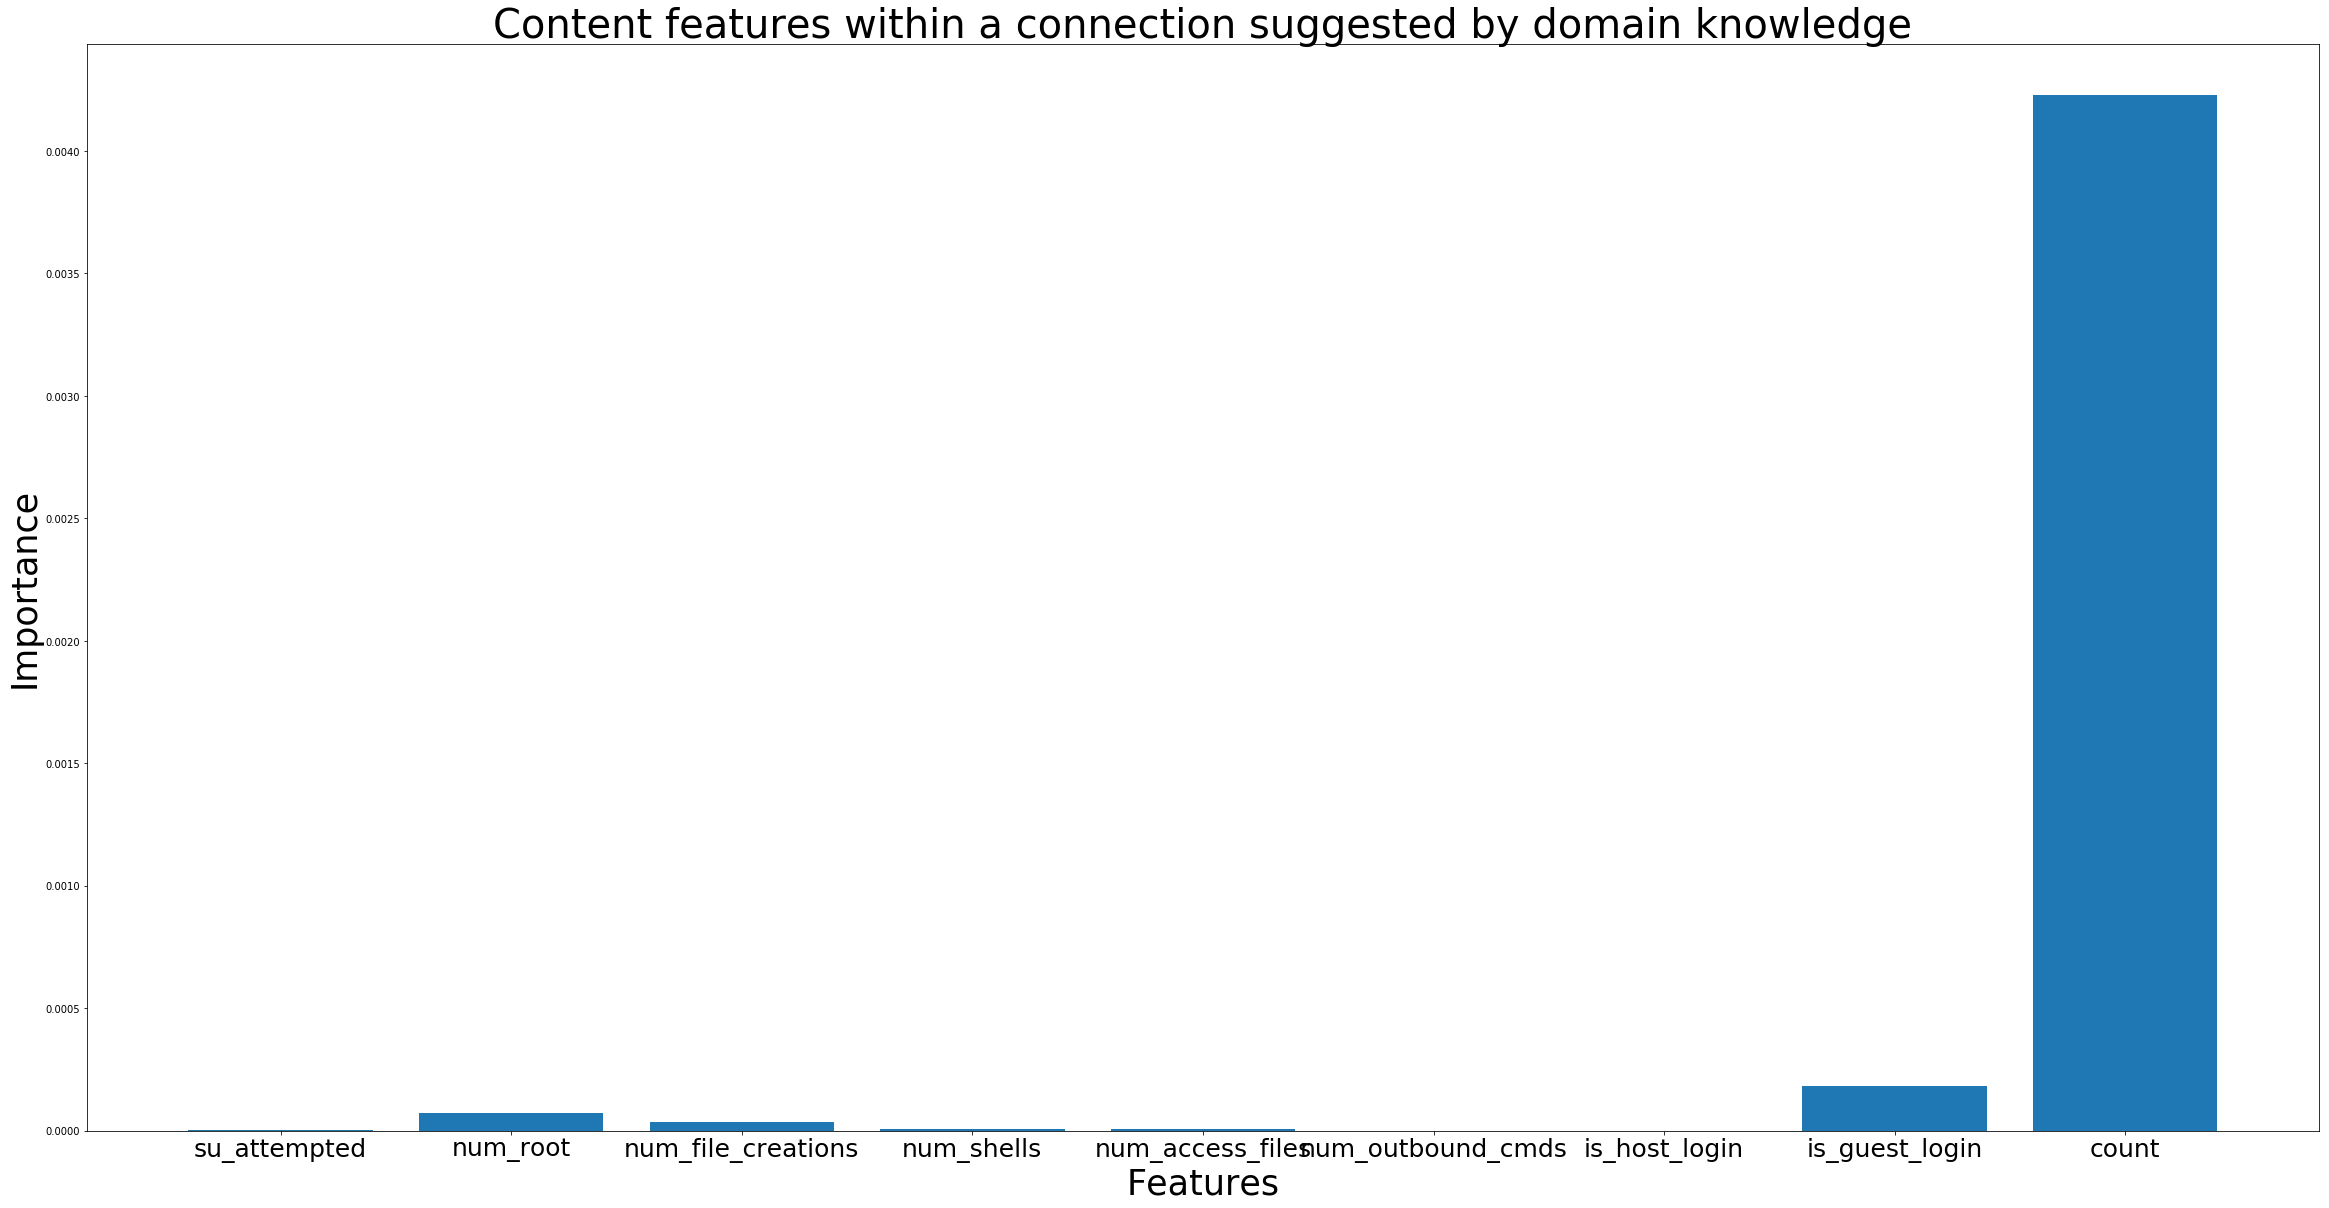

In [294]:
y_pos = np.arange(len(train_data.iloc[:,11:20].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, random_forest.feature_importances_[11:20], align='center')
plt.xticks(y_pos, train_data.iloc[:,11:20].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Content features within a connection suggested by domain knowledge", fontsize=40)
plt.show()

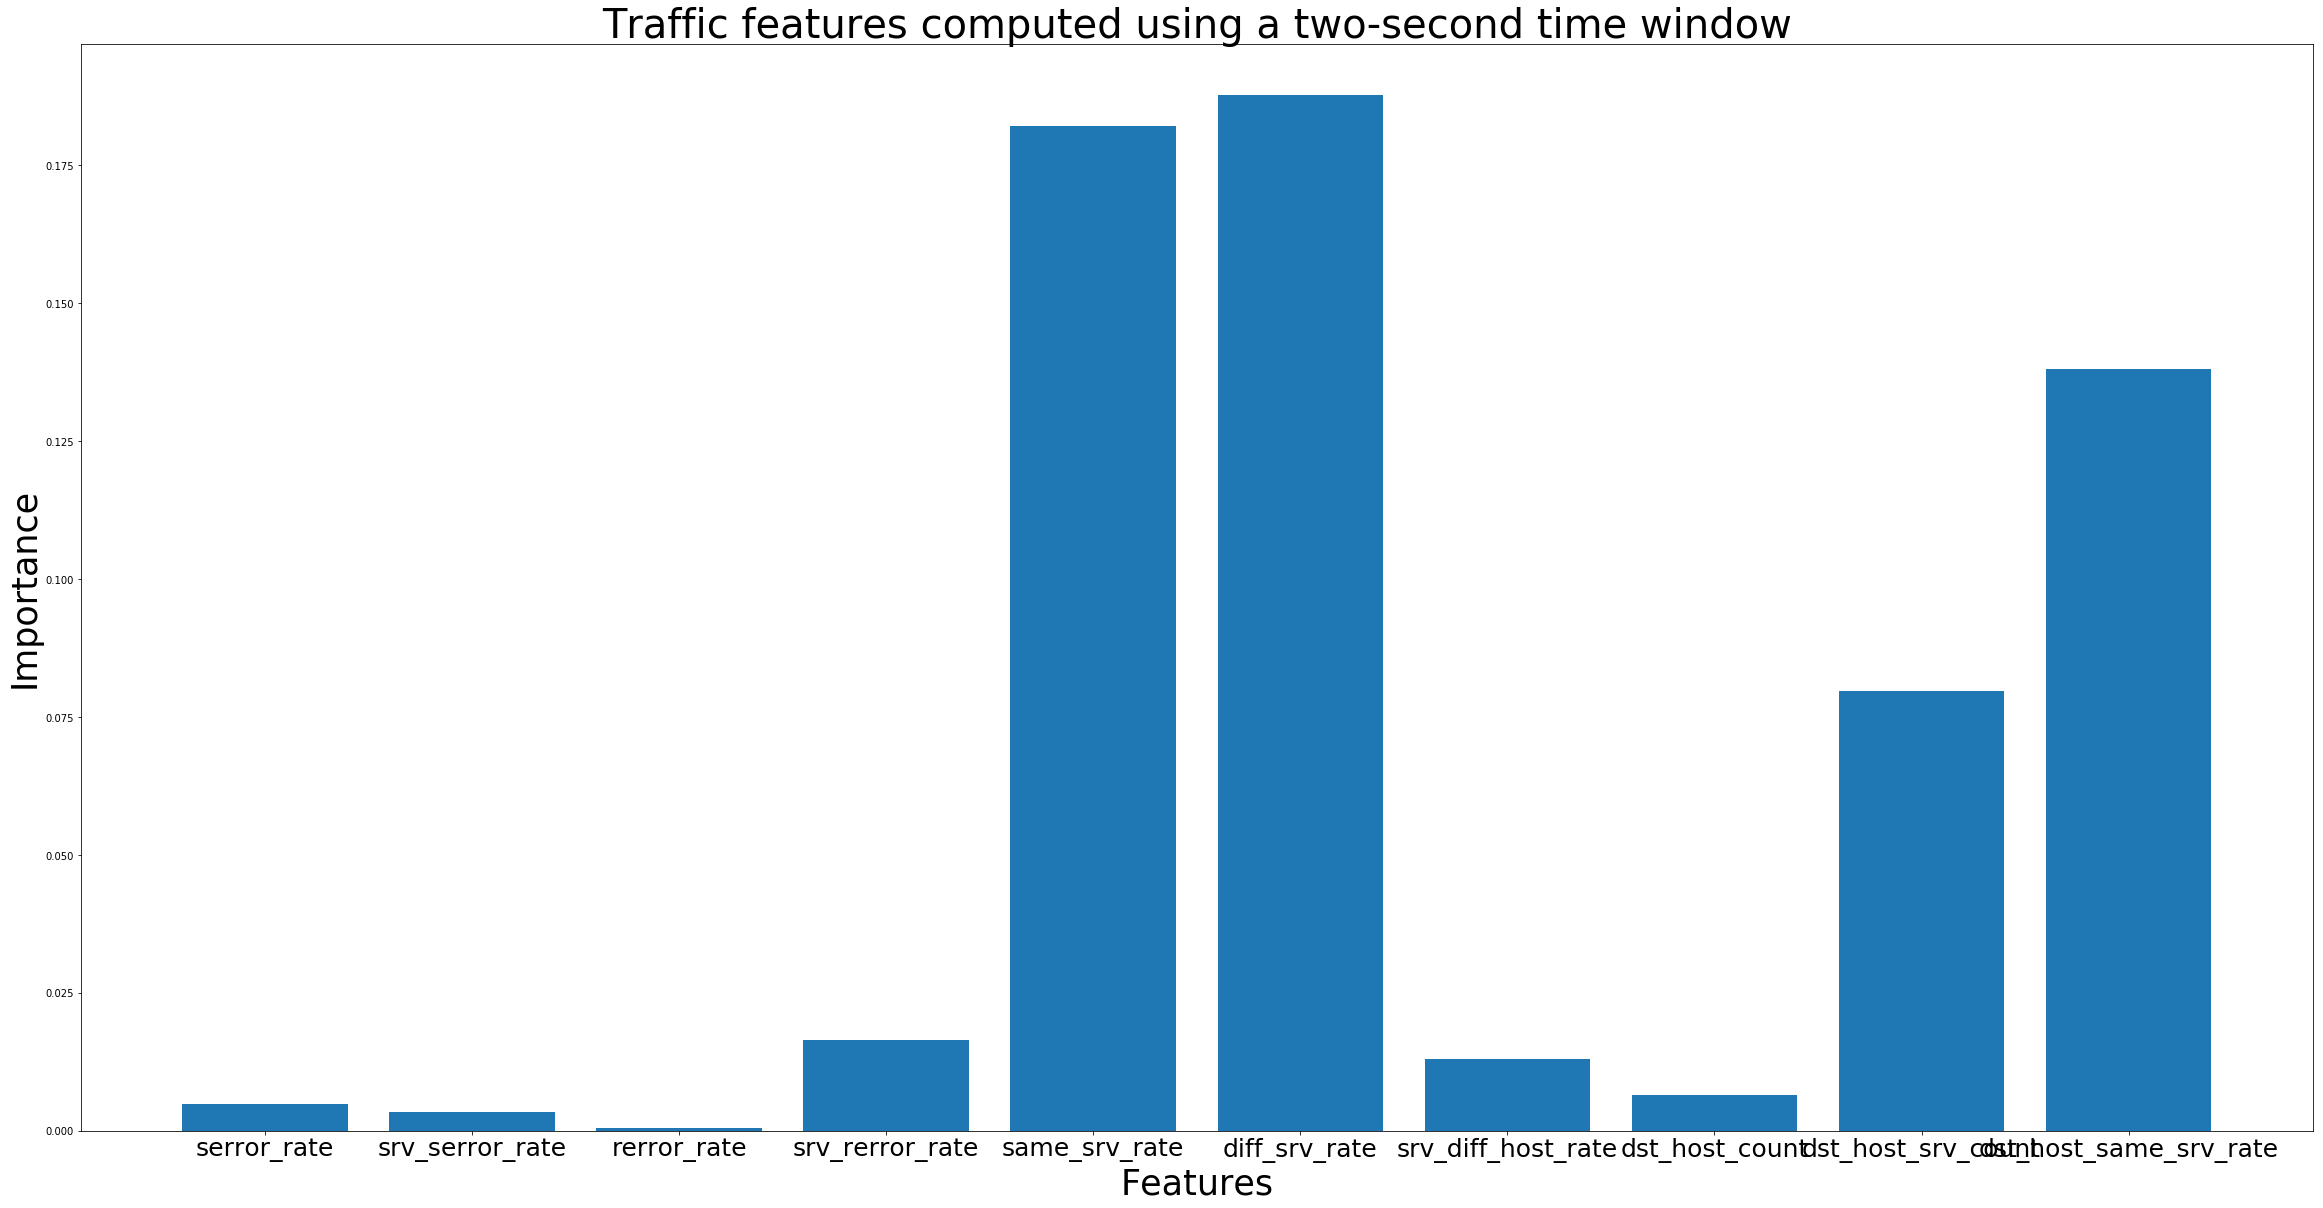

In [295]:
y_pos = np.arange(len(train_data.iloc[:,21:31].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, random_forest.feature_importances_[21:31], align='center')
plt.xticks(y_pos, train_data.iloc[:,21:31].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Traffic features computed using a two-second time window", fontsize=40)
plt.show()

Now, for Gradient Boosting.

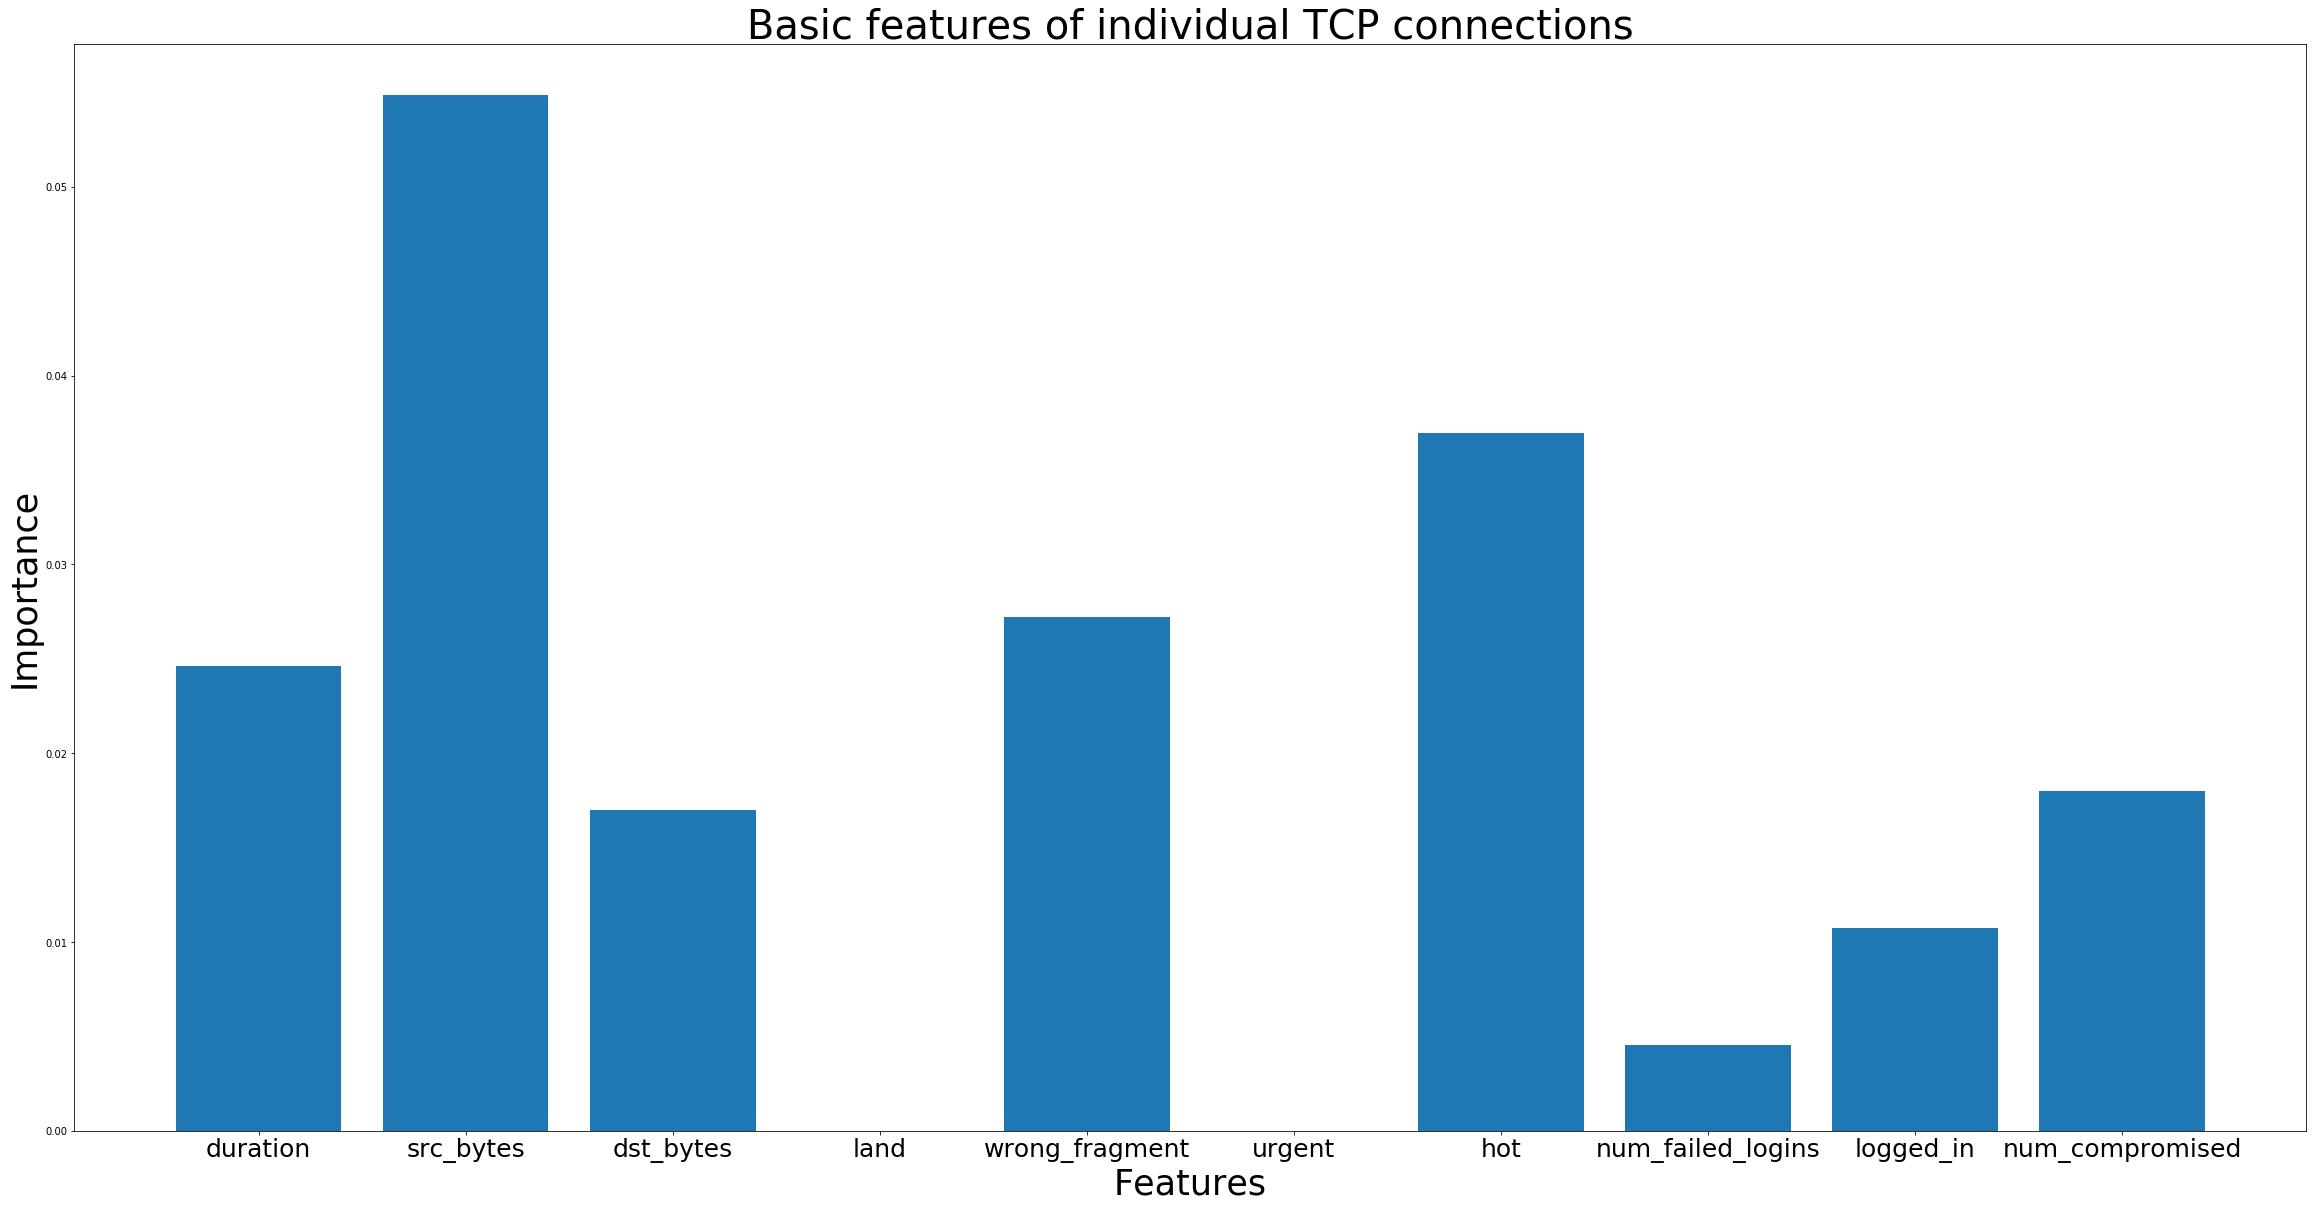

In [296]:
y_pos = np.arange(len(train_data.iloc[:,0:10].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, gradient_boosting.feature_importances_[0:10], align='center')
plt.xticks(y_pos, train_data.iloc[:,0:10].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Basic features of individual TCP connections", fontsize=40)
plt.show()

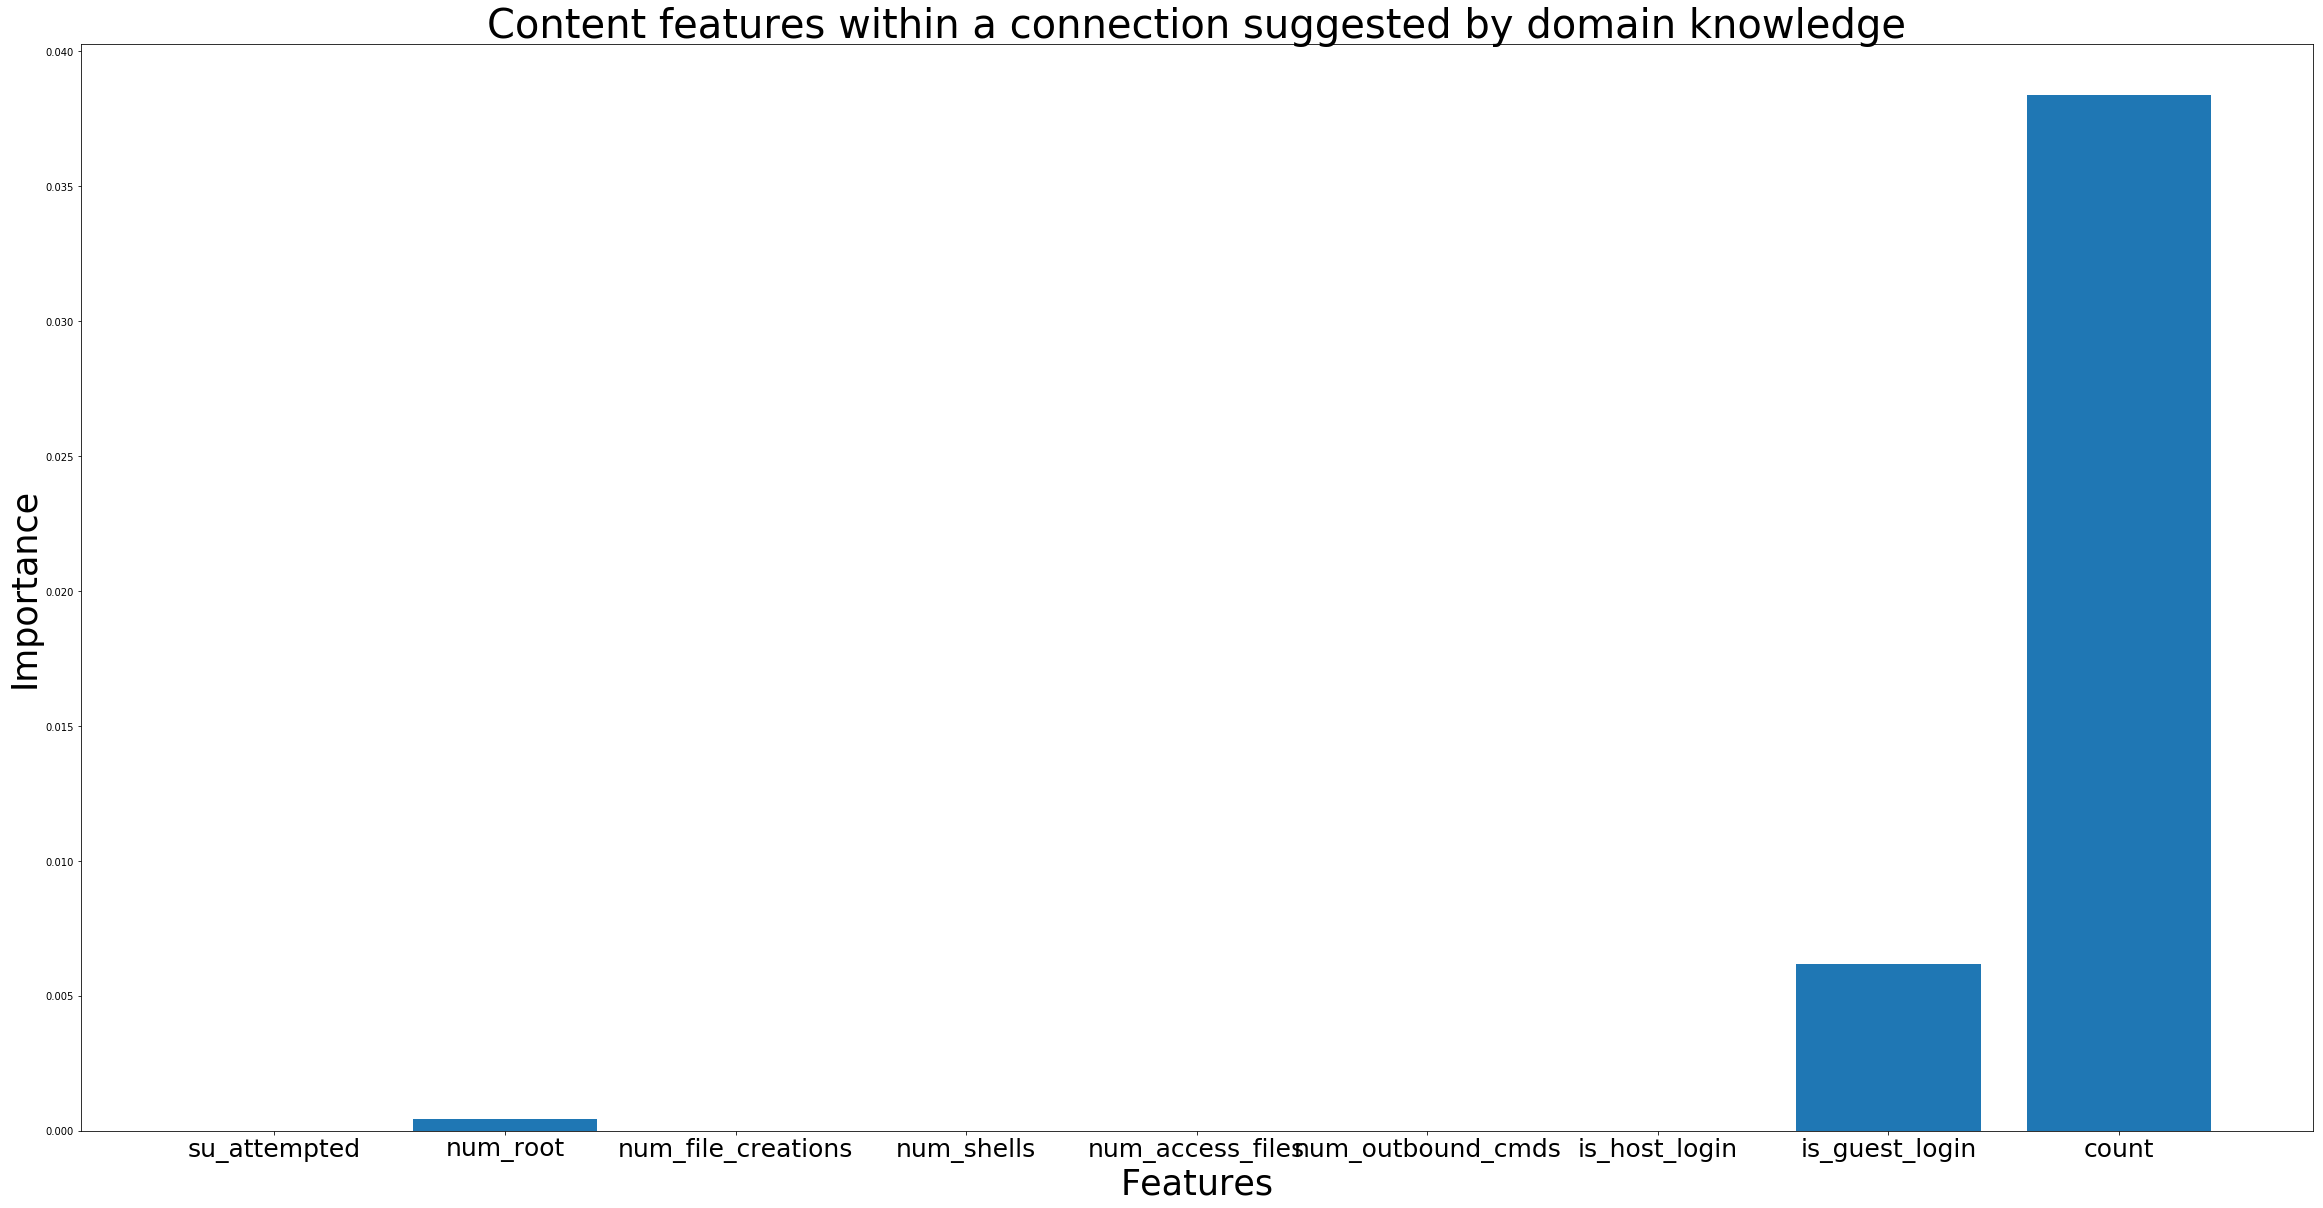

In [297]:
y_pos = np.arange(len(train_data.iloc[:,11:20].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, gradient_boosting.feature_importances_[11:20], align='center')
plt.xticks(y_pos, train_data.iloc[:,11:20].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Content features within a connection suggested by domain knowledge", fontsize=40)
plt.show()

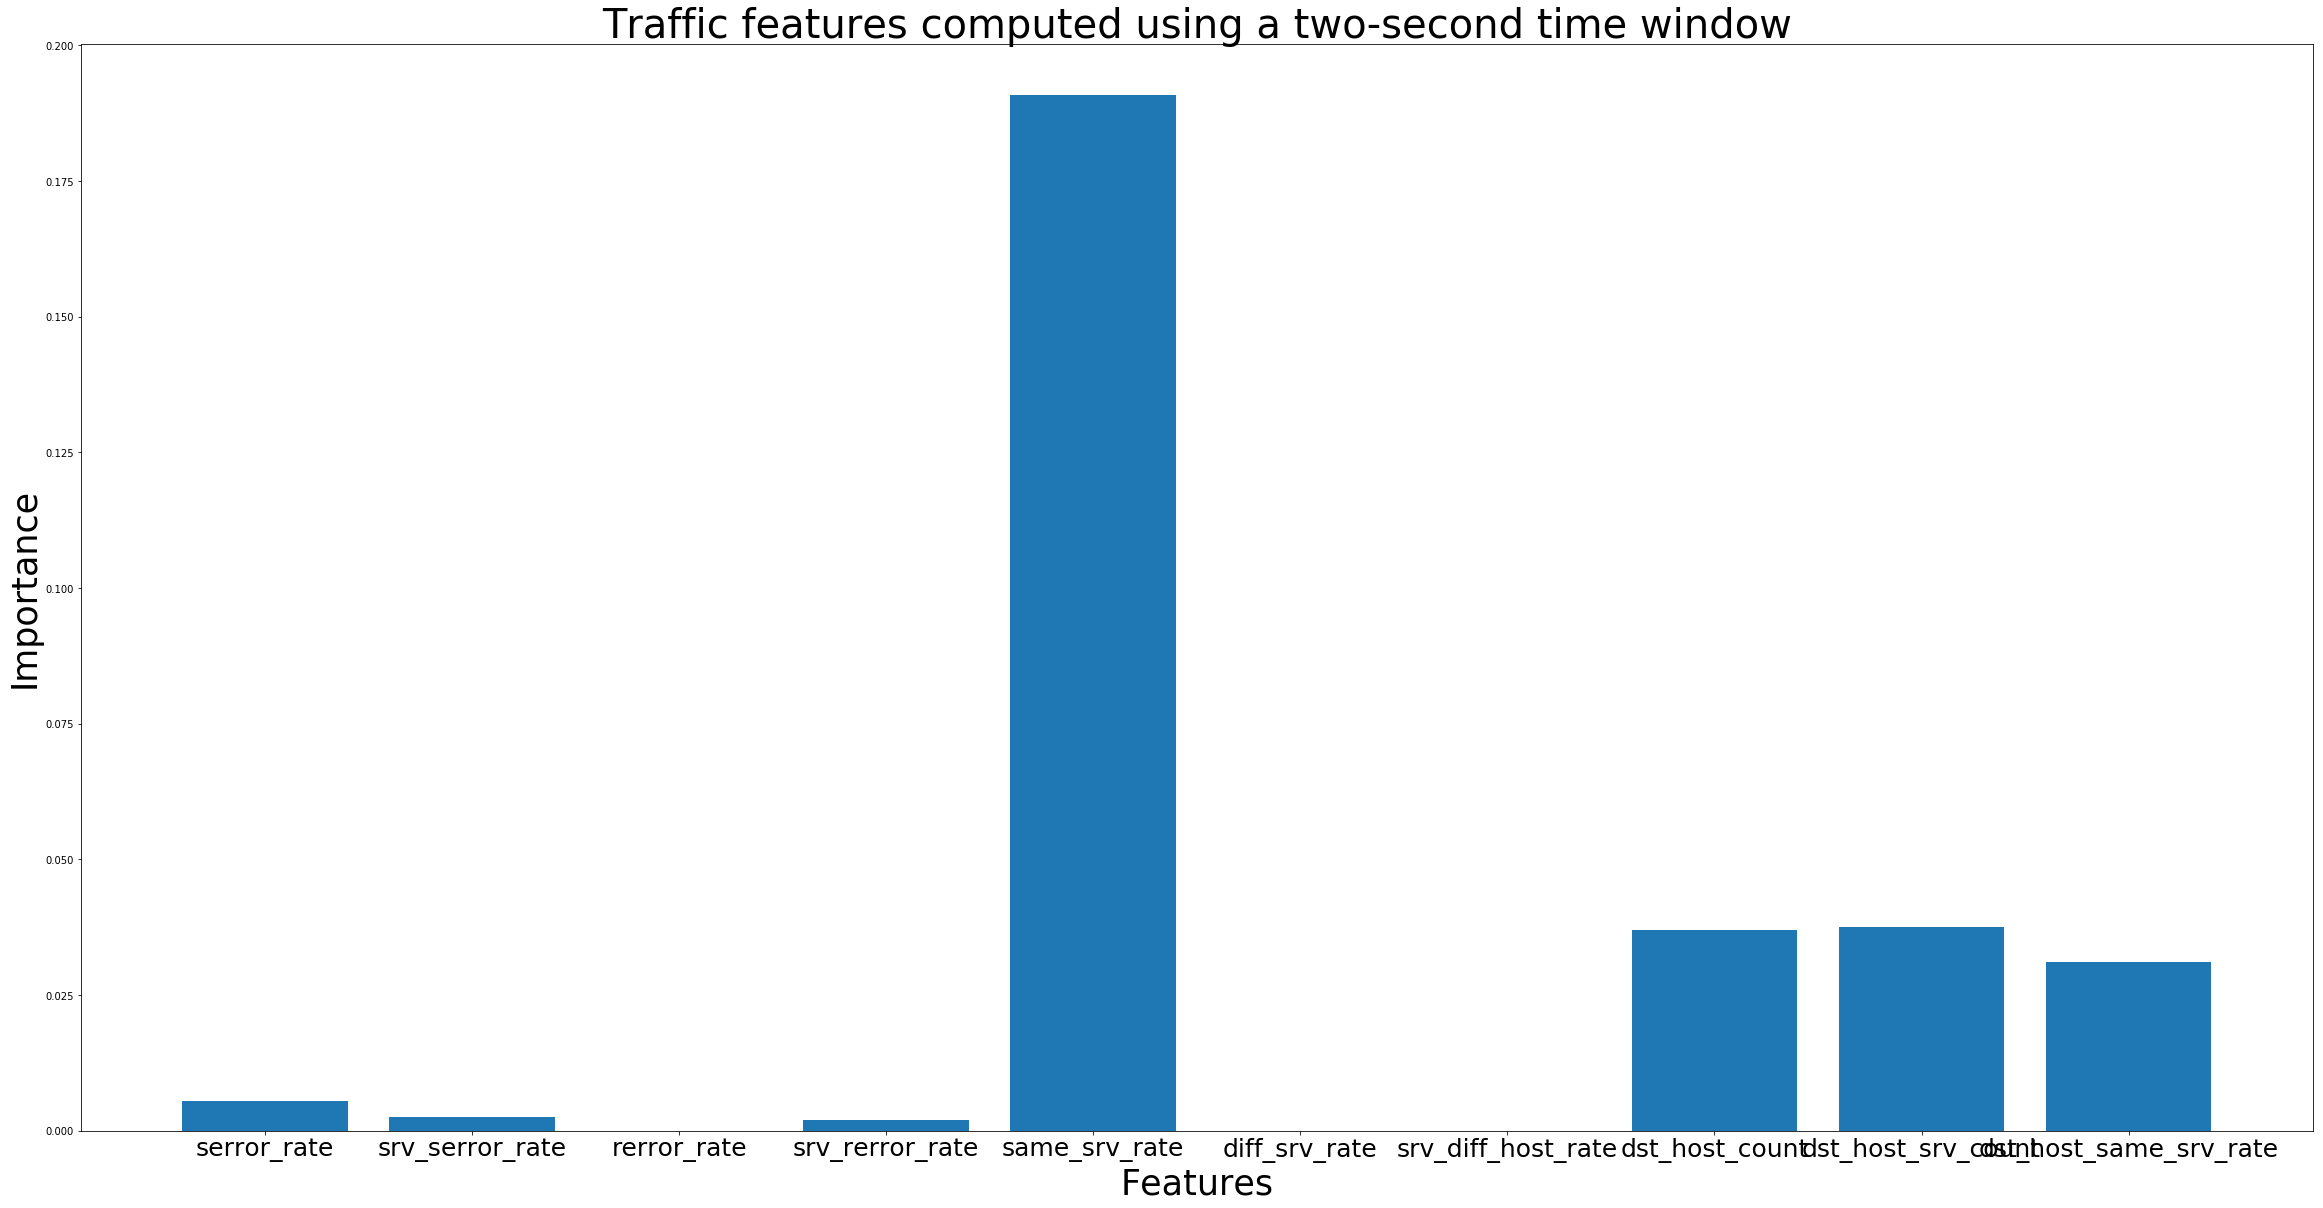

In [298]:
y_pos = np.arange(len(train_data.iloc[:,21:31].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, gradient_boosting.feature_importances_[21:31], align='center')
plt.xticks(y_pos, train_data.iloc[:,21:31].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Traffic features computed using a two-second time window", fontsize=40)
plt.show()

For Random Forest, the traffic features of the connections are more important and predictive than others. But, for Gradient Boosting, the basic features of connections are more important.

## Model Tuning

Let's try to use the important features and see how the classfiers perform.

In [299]:
random_forest = RandomForestClassifier().fit(train_data[["logged_in", "count", "serror_rate", "same_srv_rate", "diff_srv_rate"]], train_data["label"])
print accuracy_score(test_data["label"], random_forest.predict(test_data[["logged_in", "count", "serror_rate", "same_srv_rate", "diff_srv_rate"]])) * 100
fpr, tpr, thresholds = roc_curve(test_data["label"], random_forest.predict(test_data[["logged_in", "count", "serror_rate", "same_srv_rate", "diff_srv_rate"]]))
roc_auc = auc(fpr, tpr)
print roc_auc

81.0927598391
0.877592808823


In [300]:
gradient_boosting = GradientBoostingClassifier().fit(train_data[["src_bytes", "hot", "count", "same_srv_rate"]], train_data["label"])
print accuracy_score(test_data["label"], gradient_boosting.predict(test_data[["src_bytes", "hot", "count", "same_srv_rate"]])) * 100
fpr, tpr, thresholds = roc_curve(test_data["label"], gradient_boosting.predict(test_data[["src_bytes", "hot", "count", "same_srv_rate"]]))
roc_auc = auc(fpr, tpr)
print roc_auc

91.6895209128
0.943690045203


Let's tune the out of the box Random Forest classifier by tweaking some of the parameters.

criterion:

In [301]:
criterions = ["gini", "entropy"]
for criterion in criterions:
    random_forest = RandomForestClassifier(criterion=criterion).fit(train_data.iloc[:,:-1], train_data["label"])
    print criterion
    print accuracy_score(test_data["label"], random_forest.predict(test_data.iloc[:,:-1])) * 100
    fpr, tpr, thresholds = roc_curve(test_data["label"], random_forest.predict(test_data.iloc[:,:-1]))
    roc_auc = auc(fpr, tpr)
    print roc_auc
    print "\n"

gini
92.274032325
0.945543221166


entropy
92.4135691527
0.951038602547




So, there is not much difference in the results when we use 'gini' or 'entropy'.

In [314]:
split = [2,5,8,10]
leaf = [1,5,7,10]

accuracy_scores = []
auc_scores = []
for i in xrange(0,len(split)):
    temp_accuracy_scores = []
    temp_auc_scores = []
    for j in xrange(0,len(leaf)):
        print str(split[i]) + "\t" + str(leaf[j])
        random_forest = RandomForestClassifier(min_samples_split=split[i], min_samples_leaf=leaf[j])
        random_forest.fit(train_data.iloc[:,:-1], train_data["label"])

        accuracy = accuracy_score(test_data["label"], random_forest.predict(test_data.iloc[:,:-1])) * 100
        temp_accuracy_scores.append(accuracy)
        
        fpr, tpr, thresholds = roc_curve(test_data["label"], random_forest.predict(test_data.iloc[:,:-1]))
        roc_auc = auc(fpr, tpr)
        temp_auc_scores.append(roc_auc)
        
        print accuracy
        print roc_auc
        print "\n"
    accuracy_scores.append(temp_accuracy_scores)
    auc_scores.append(temp_auc_scores)

2	1
92.3711293802
0.949824262613


2	5
92.2769259458
0.946261778969


2	7
92.4380041732
0.949420099288


2	10
92.1772567831
0.944867206104


5	1
92.6064772095
0.95222400287


5	5
92.490410862
0.951428196723


5	7
92.3839899173
0.950967517567


5	10
92.4717630832
0.949360757497


8	1
92.6074417498
0.952067355659


8	5
92.4087464513
0.946636227906


8	7
92.3270820406
0.946654554171


8	10
92.3470158731
0.946409277941


10	1
92.4900893486
0.951276073961


10	5
92.235772227
0.945274359214


10	7
92.4084249379
0.951112997681


10	10
92.4601885998
0.950308490257




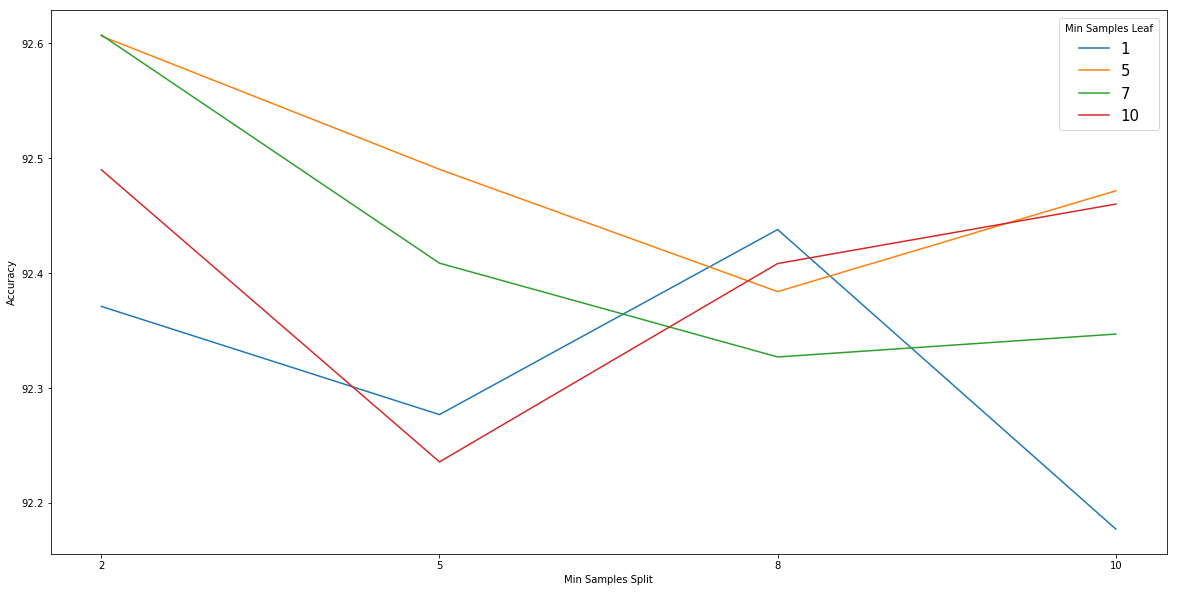

In [315]:
y_pos = np.arange(len(split))
plt.figure(figsize=(20, 10))
for i in xrange(0,len(accuracy_scores)):
    plt.plot(accuracy_scores[i], label=leaf[i])
plt.ylabel("Accuracy")
plt.xlabel("Min Samples Split")
plt.xticks(y_pos, split)
plt.legend(title="Min Samples Leaf", prop={"size": 15})
plt.show()

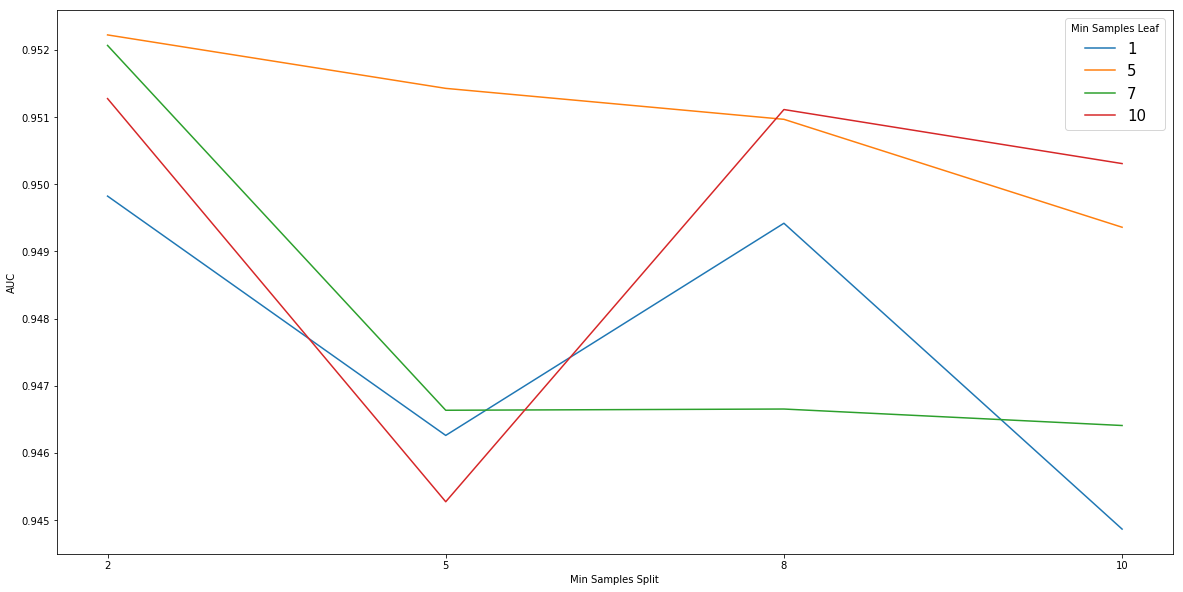

In [316]:
y_pos = np.arange(len(split))
plt.figure(figsize=(20, 10))
for i in xrange(0,len(auc_scores)):
    plt.plot(auc_scores[i], label=leaf[i])
plt.ylabel("AUC")
plt.xlabel("Min Samples Split")
plt.xticks(y_pos, split)
plt.legend(title="Min Samples Leaf", prop={"size": 15})
plt.show()

As we see, the min samples split and min samples leaf parameters, do not affect the results much.

Now, let's try to tweak the Logistic Regression model.

In [317]:
cs = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
log_cs = []

accuracy_scores = []
auc_scores = []
for c in cs:
    log_c = np.log10(c)
    log_cs.append(log_c)
    print log_c

    logreg = LogisticRegression(C=c)
    logreg.fit(train_data.iloc[:,:-1], train_data["label"])

    accuracy = accuracy_score(test_data["label"], logreg.predict(test_data.iloc[:,:-1])) * 100
    accuracy_scores.append(accuracy)

    fpr, tpr, thresholds = roc_curve(test_data["label"], logreg.predict(test_data.iloc[:,:-1]))
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    print accuracy
    print roc_auc
    print "\n"

-6.0
25.2539152298
0.535839230213


-5.0
38.9423494272
0.620740902986


-4.0
39.1404016989
0.621495358345


-3.0
83.7089146028
0.893219205621


-2.0
91.7338897659
0.941732436811


-1.0
91.8004430455
0.941983079287


0.0
91.9023628022
0.942678528118


1.0
91.8940034531
0.942576576566


2.0
91.9190815004
0.942738560236


3.0
91.9126512319
0.942679864094


4.0
91.9197245273
0.942705021711


5.0
91.9084715573
0.942653909359


6.0
91.9149018259
0.94267507394




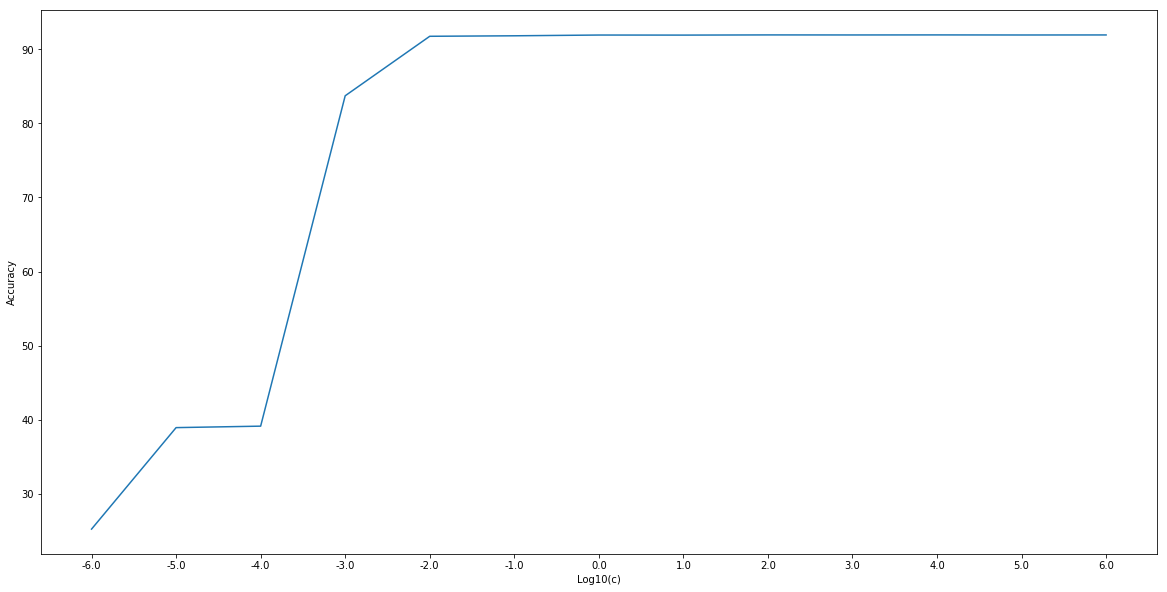

In [319]:
y_pos = np.arange(len(log_cs))
plt.figure(figsize=(20, 10))
plt.plot(accuracy_scores)
plt.xticks(y_pos, log_cs)
plt.ylabel("Accuracy")
plt.xlabel("Log10(c)")
plt.show()

We observe that the model does not perform well for C at powers of 10 below -1. But it does so fairly equally at higher powers. So we can keep the C value at 1.0 (default).